In [44]:
# Import the following libraries and functions
from utils.load_data import load_data
from utils.filters import highpass_filter, lowpass_filter
import numpy as np
from utils.plot_signal import plot_signal # NOTE: WE DO NOT USE THIS FUNCTION IN THIS SCRIPT
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from utils.model import train_linear_model, create_lagged_features

In [45]:
# Load data
data_abdomen1, data_abdomen2, data_abdomen3, data_thorax1, data_thorax2 = load_data()

# Preprocessing & Signal Processing
1. Normalization
2. High pass filter

#### Failed attempts
1. ***Naive first approach of subtraction - could not successfully isolate.*** <!--Require some input from Aras here-->
2. Band-pass filtering - gives signal which looks like sinusoid.
3. Removing combined signal maximums to try and obtain child. Noise was problematic and combined signal wasnt able to be disected.

## Normalization

In [46]:
# Normalize the data to unit variance and zero mean for each channel
thorax1 = (data_thorax1 - data_thorax1.mean()) / data_thorax1.std()
thorax2 = (data_thorax2 - data_thorax2.mean()) / data_thorax2.std()
abdomen1 = (data_abdomen1 - data_abdomen1.mean()) / data_abdomen1.std()
abdomen2 = (data_abdomen2 - data_abdomen2.mean()) / data_abdomen2.std()
abdomen3 = (data_abdomen3 - data_abdomen3.mean()) / data_abdomen3.std()
# Create a copy of abdomen3 normalized to unit variance and zero mean
normalized_abdomen3 = (data_abdomen3 - data_abdomen3.mean()) / data_abdomen3.std()

## High Pass Filter
Used to remove the wandering baseline from the signals recorded in each channel.

Parameter justification:
  - Order = 2: Minimizes the phase distortion while surpressing low-frequency artifacts adequately.
  - cutoff_baseline_thorax = 0.5: Baseline wander is around 0.5. There aren't much high frequency artifacts here, so the cutoff here makes the most sense.
  - cutoff_baseline_abdomen = 30: Baseline wander is around 0.5. However, more artifacts are here such as motion artifacts. Hence, a higher cutoff was needed. 

In [47]:
# High pass filter to remove baseline wanderboth types of channels
# Cutoff frequencies for 
cutoff_baseline_thorax = 0.5
cutoff_baseline_abdomen = 30
# Sampling frequency
fs = 1000

# Apply high pass filter to remove baseline wander
thorax1 = highpass_filter(thorax1, cutoff_baseline_thorax, fs, order=2)
thorax2 = highpass_filter(thorax2, cutoff_baseline_thorax, fs, order=2)
abdomen1 = highpass_filter(abdomen1, cutoff_baseline_abdomen, fs, order=2)
abdomen2 = highpass_filter(abdomen2, cutoff_baseline_abdomen, fs, order=2)
abdomen3 = highpass_filter(abdomen3, cutoff_baseline_abdomen, fs, order=2)

## Linear Model - Attempt #1


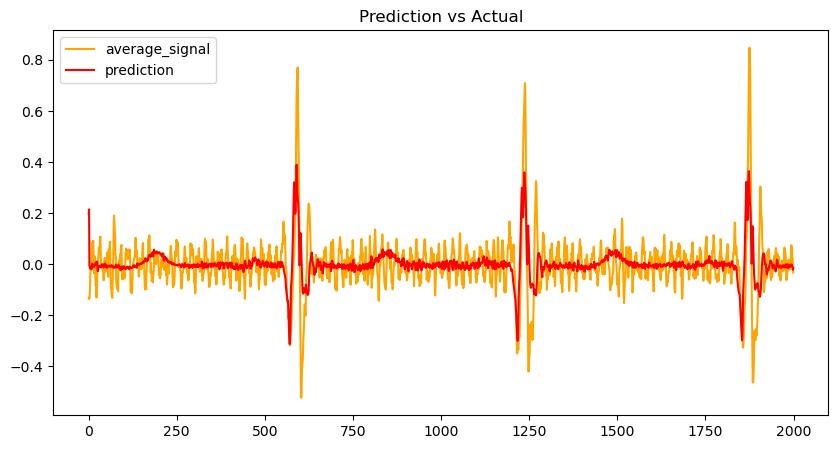

Mean Squared Error on Test Set: 0.0154


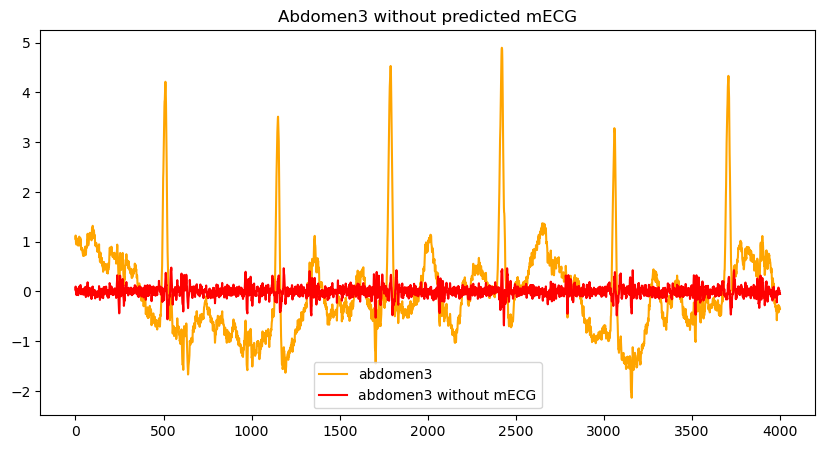

In [48]:
# NOTE: Aras, can you verify that the comments below is making sense with the code?
# Reshape the data to be used in the linear model
thorax1 = thorax1.reshape(-1, 1)
thorax2 = thorax2.reshape(-1, 1)
abdomen1 = abdomen1.reshape(-1, 1)
abdomen2 = abdomen2.reshape(-1, 1)
abdomen3 = abdomen3.reshape(-1, 1)


# Create lagged features for thorax1 and thorax2
thorax1_lagged = create_lagged_features(thorax1)
thorax2_lagged = create_lagged_features(thorax2)

# Train linear model
linear_model = train_linear_model(np.hstack((thorax1_lagged, thorax2_lagged)), (abdomen1 + abdomen2) / 2)


# Predict using linear model
linear_prediction = linear_model.predict(np.hstack((thorax2_lagged, thorax2_lagged))) # <- is thorax2 twice correct?

# Show the average between abdomen1 and abdomen2 compared to predicted abdominal mECG
plt.figure(figsize=(10,5))
plt.plot((abdomen1[:2000] + abdomen2[:2000]) / 2, label='average_signal', color='orange')
plt.plot(linear_prediction[:2000], label='prediction', color='red')
plt.title("Prediction vs Actual")
plt.legend()
plt.show()

# Measure performance
mse = mean_squared_error(abdomen2, linear_prediction)
print(f"Mean Squared Error on Test Set: {mse:.4f}")

# Flatten the abdomen3 data to be used in the plot
abdomen3_flattened_normalized = normalized_abdomen3.values.flatten()

# Show abdomen3 compared to predicted abdomen3 without mECG
plt.figure(figsize=(10,5))
plt.plot(abdomen3_flattened_normalized[2000:6000], label='abdomen3', color='orange')
plt.plot((abdomen3[:6000] - linear_prediction[:6000])[2000:6000], label='abdomen3 without mECG', color='red')
plt.title("Abdomen3 without predicted mECG")
plt.legend()
plt.show()

## Linear Model- Attempt #2
We realized we need larger windows to train our model onl. If our time series features are sparse, we should ensure the windows are large enough to incorporate it.

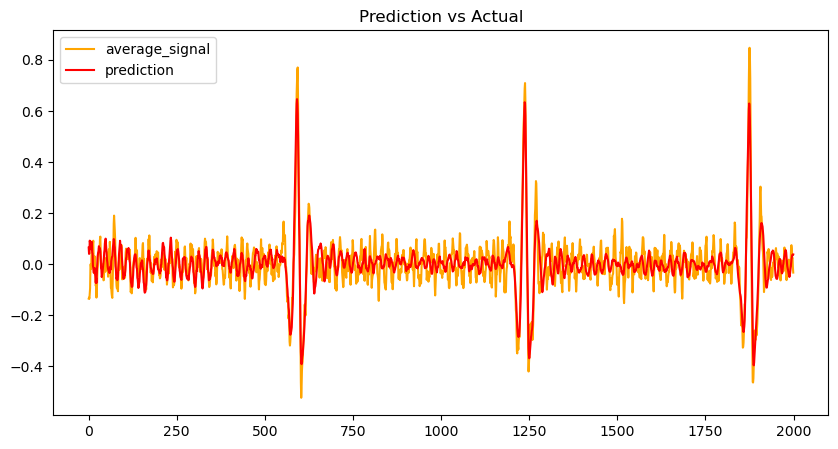

Mean Squared Error on Test Set: 0.0095


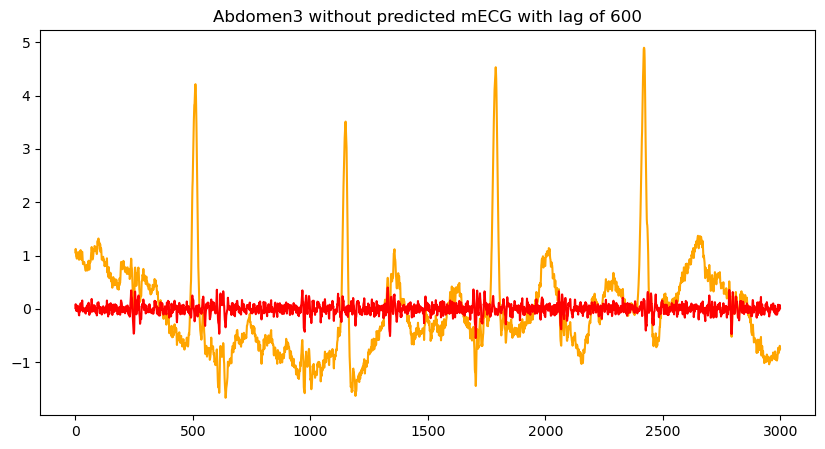

In [49]:
# Create lagged features for thorax1 and thorax2 with a lag of 600 window size
thorax1_lagged = create_lagged_features(thorax1, 600)
thorax2_lagged = create_lagged_features(thorax2, 600)

# Train linear model
linear_model = train_linear_model(np.hstack((thorax1_lagged, thorax2_lagged)), (abdomen1 + abdomen2) / 2)

# Predict using linear model
linear_prediction = linear_model.predict(np.hstack((thorax2_lagged, thorax2_lagged)))

# Show the average between abdomen1 and abdomen2 compared to predicted abdominal mECG
plt.figure(figsize=(10,5))
plt.plot((abdomen1[:2000] + abdomen2[:2000]) / 2, label='average_signal', color='orange')
plt.plot(linear_prediction[:2000], label='prediction', color='red')
plt.title("Prediction vs Actual")
plt.legend()
plt.show()

# Measure performance
mse = mean_squared_error(abdomen2, linear_prediction)
print(f"Mean Squared Error on Test Set: {mse:.4f}")

# Flatten the abdomen3 data to be used in the plot
abdomen3_flattened_normalized = normalized_abdomen3.values.flatten()

# Show abdomen3 compared to predicted abdomen3 without mECG
plt.figure(figsize=(10,5))
plt.plot(abdomen3_flattened_normalized[2000:5000], label='abdomen3', color='orange')
plt.plot((abdomen3[:6000] - linear_prediction[:6000])[2000:5000], label='abdomen3 without mECG', color='red')
plt.title("Abdomen3 without predicted mECG with lag of 600")
plt.show()

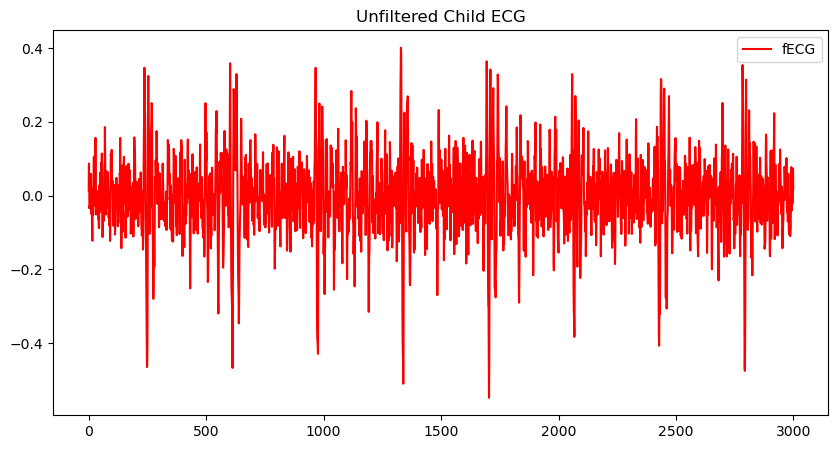

In [50]:
# Subtract the linear prediction from the abdomen3 signal to obtain noisy fECG
result = (abdomen3[:6000] - linear_prediction[:6000])[2000:5000]

#Plot the unfiltered result
plt.figure(figsize=(10,5))
plt.plot(result, label='fECG', color='red')
plt.title("Unfiltered Child ECG")
plt.legend()
plt.show()

## Postprocessing

After the unfiltered signal seen above, we need to perform some postprocessing in order to obtain a clearer child image with almost twice the frequency of the mother.

1. Squaring the signal: Amplifies peaks of the heartbeat signals, which have higher amplitudes than background noise. Also it converts both positive and negative signal deflections into positive values, effectively measuring signal "energy." Hence, the fetal ECG becomes more distinguishable from random noise.
2. Moving Average Filter: Smoothes the squared signal by averaging over a window while retaining the fetal ECG. The peaks average out to the high "bursts of energy" in the signal, while the noise is averaged out to zero, effictively removing the noise

### Squaring the Signal

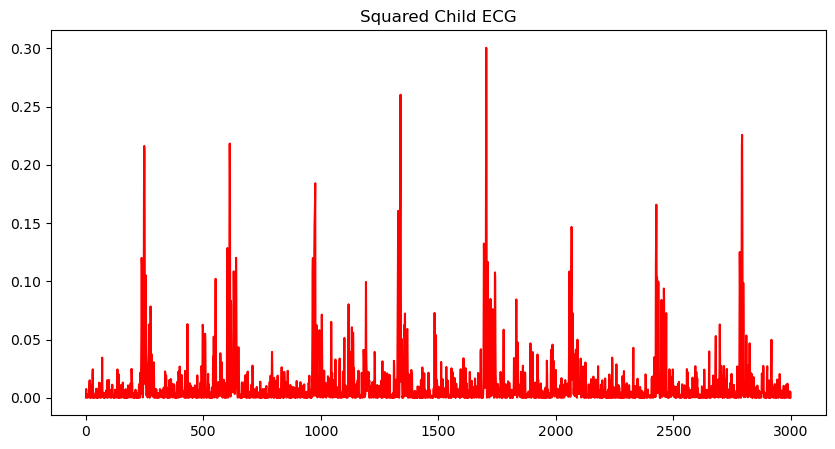

In [51]:
# Square the result
result = result ** 2

#Plot the squared result
plt.figure(figsize=(10,5))
plt.plot(result, label='fECG', color='red')
plt.title("Squared Child ECG")
plt.show()

### Moving Average Signal

Parameter Justification:

window_size = 50: Perfect balance between blurring importnat features (smoothing too much), and noise (not enough smoothing). Works since the fetal heart rate is higher than the maternal


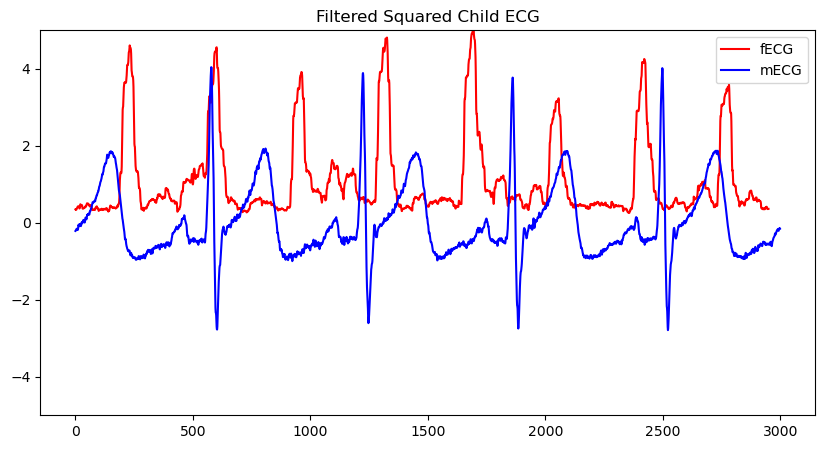

In [ ]:
#Apply moving average filter to the squared result
window_size = 50
result_convolved = np.convolve(result.flatten(), np.ones(window_size)/window_size, mode='valid')

# Multiply the result by 100 for visualization purposes
result_convolved = result_convolved * 100

#Plot the filtered squared result compared to the mECG, which is thorax1
plt.figure(figsize=(10,5))
plt.plot(result_convolved, label='fECG', color='red')
plt.plot(thorax1[:3000], label='mECG', color='blue')
plt.legend()
plt.ylim(-5, 5)
plt.title("Filtered Squared Child ECG")
plt.show()